# benchmark multiple openai models using repetitive sums dataset and few token completion method  

We give the chat completion api a chat hisotry that contains part of the assistant response and only ask for a few tokens back.  

From there, we extract the response.  

## install libs

In [1]:
!pip install datasets openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

## inference function  

openai models can answer from 2 to 100 using a single token.  

### define inference function  



In [41]:
from openai import OpenAI
from google.colab import userdata
import time

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def extract_number(input_str):
  try:
    return int(''.join(filter(str.isdigit, input_str)))
  except ValueError:
    return 0

extract_number("bla bla . bla bla"), extract_number("bla bla 22 bla bla")

def get_sum_result(current_sum, curr_model):
  while True:
    try:
      response = client.chat.completions.create(
        model=curr_model,
        messages=[
          {"role": "system", "content": "You are a helpful assistant. Answer with a single token."},
          {"role": "user", "content": f"What is the result of the following sum : {current_sum} ?"},
        ],
        max_tokens = 1
      )
      return extract_number(response.choices[0].message.content )
    except Exception: #catch http 429 here
      print("Retrying...")
      time.sleep(60)

### test inference function

In [42]:
test_sums = [
  '1+1',
  '2+2',
  '50+50'
]

models_to_test = [
    "gpt-4o-2024-05-13",
    "gpt-4-turbo-2024-04-09",
    "gpt-4-0125-preview",
    "gpt-4-1106-preview",
    "gpt-4-0613",
    "gpt-3.5-turbo-0125",
    "gpt-3.5-turbo-1106",
]

for curr_model in models_to_test:
  print(f"--- Testing model : {curr_model} ---")
  for curr_sum in test_sums:
    llm_result = get_sum_result(curr_sum, curr_model)
    is_success = llm_result  == eval(curr_sum)
    if is_success:
      print(f"✅ {curr_sum} = {llm_result}")
    else:
      print(f"❌ {curr_sum} = {llm_result}")



--- Testing model : gpt-4o-2024-05-13 ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gpt-4-turbo-2024-04-09 ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gpt-4-0125-preview ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gpt-4-1106-preview ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gpt-4-0613 ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gpt-3.5-turbo-0125 ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gpt-3.5-turbo-1106 ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100


## define benchmark functions

In [43]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 4

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)

def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()


## Load dataset

In [44]:
from datasets import load_dataset

dataset_ds = load_dataset("the-french-artist/repetitive_sums_benchmark", split='train')
dataset_ds

Generating train split:   0%|          | 0/99 [00:00<?, ? examples/s]

Dataset({
    features: ['sum', 'result'],
    num_rows: 99
})

In [45]:
additions_df = dataset_ds.to_pandas()

## Perform inference on complete dataset  

In [49]:
models_to_test = [
    "gpt-4o-2024-05-13",
    "gpt-4-turbo-2024-04-09",
    "gpt-4-0125-preview",
    "gpt-4-1106-preview",
    "gpt-4-0613",
    "gpt-3.5-turbo-0125",
    "gpt-3.5-turbo-1106",
]
number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,gpt-4o-2024-05-13,gpt-4-turbo-2024-04-09,gpt-4-0125-preview,gpt-4-1106-preview,gpt-4-0613,gpt-3.5-turbo-0125,gpt-3.5-turbo-1106
0,1+1,2,2,2,2,2,2,2,2
1,1+1+1,3,3,3,3,3,3,3,3
2,1+1+1+1,4,4,4,4,4,4,4,4
3,1+1+1+1+1,5,5,5,5,5,5,5,5
4,1+1+1+1+1+1,6,6,6,6,6,6,6,6


## Analyze results

In [50]:
get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gpt-4o-2024-05-13,72.727273,3.666667,2.0,3.258126,1,12,0
1,gpt-4-turbo-2024-04-09,39.393939,14.850000,10.5,12.588433,1,41,0
2,gpt-4-0125-preview,44.444444,11.563636,9.0,9.681528,1,34,0
3,gpt-4-1106-preview,38.383838,13.868852,9.0,11.971460,1,42,0
4,gpt-4-0613,37.373737,8.483871,5.5,7.885953,1,30,0
5,gpt-3.5-turbo-0125,24.242424,6.573333,6.0,5.131180,1,20,0
6,gpt-3.5-turbo-1106,18.181818,7.750000,6.5,6.081940,1,23,5


<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


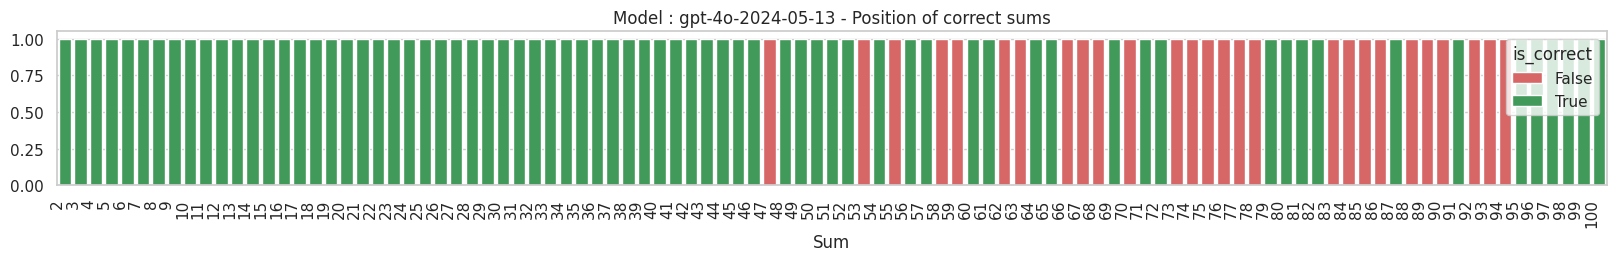

<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


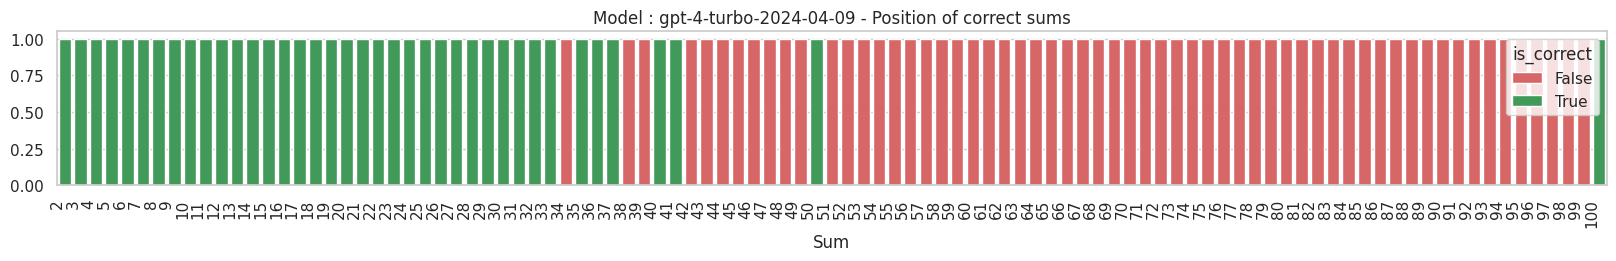

<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


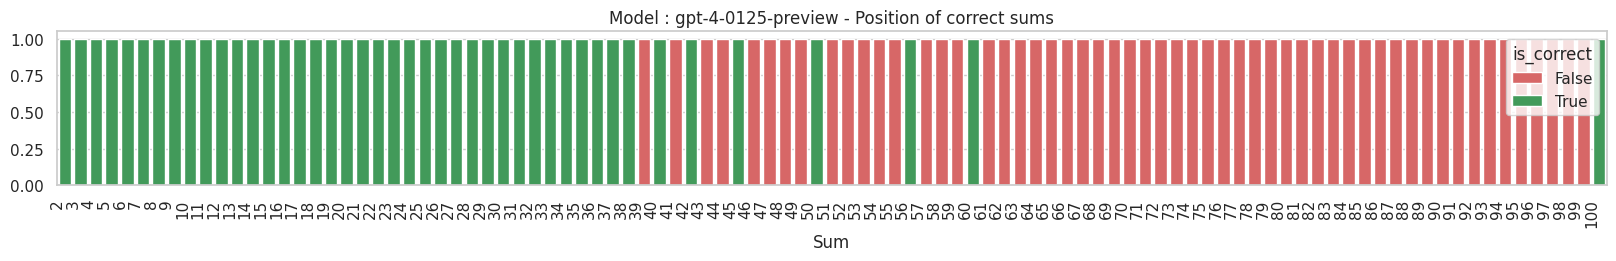

<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


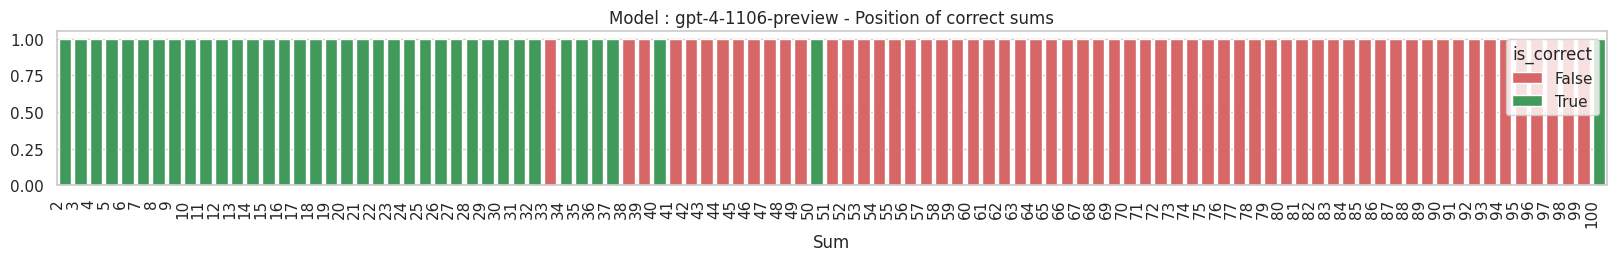

<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


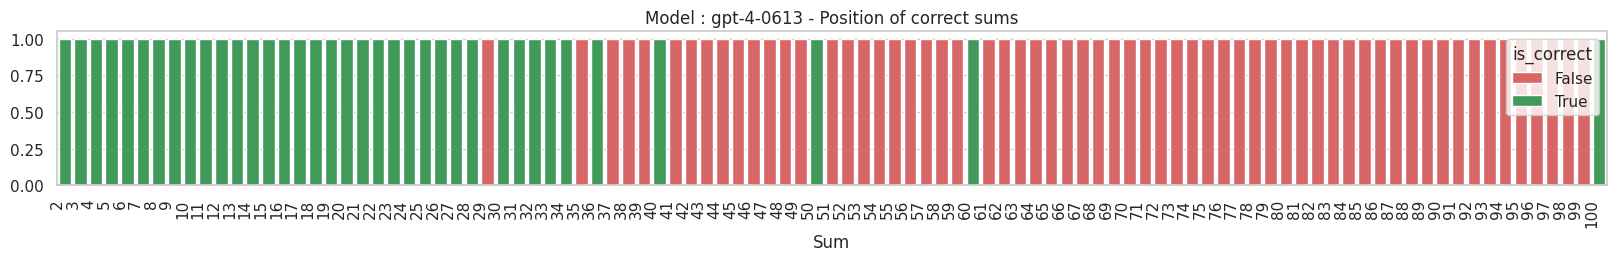

<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


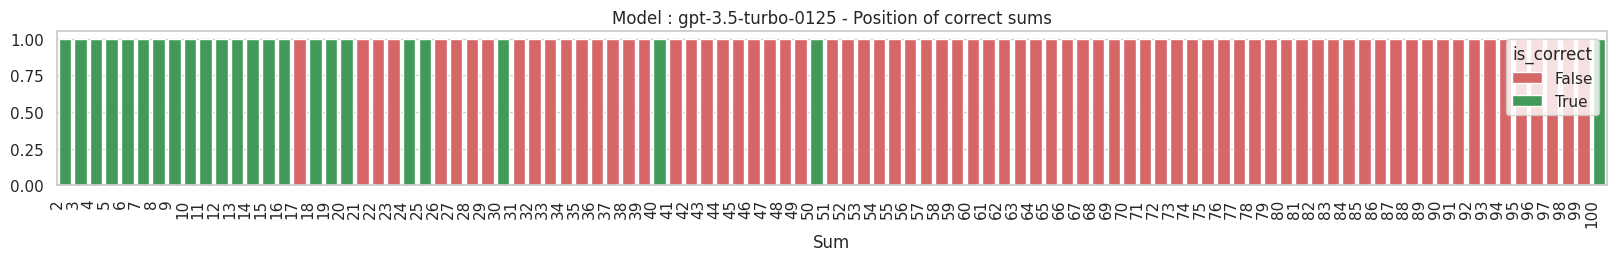

<ipython-input-43-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


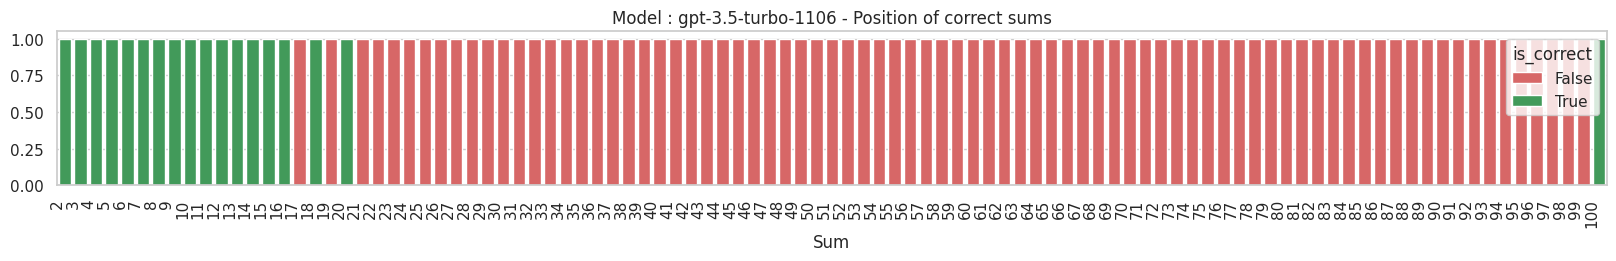

In [51]:
for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)

## update the leaderboard

In [53]:
from datasets import load_dataset

leaderboard_ds = load_dataset('the-french-artist/repetitive_sums_benchmark_leaderboard', split='train')
leaderboard_ds

Dataset({
    features: ['model_name', 'avg_accuracy', 'error_mean', 'error_median', 'error_std', 'error_min', 'error_max', 'parsing_failure_count'],
    num_rows: 20
})

In [55]:
leaderboard_df = leaderboard_ds.to_pandas()
leaderboard_df

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,mistralai/Mixtral-8x22B,34.343434,15.569231,11.0,13.677044,1,43,0
1,mistralai/Mixtral-8x22B-Instruct-v0.1,32.323232,16.059701,11.0,13.026640,1,43,0
2,Qwen/Qwen2-72B-Instruct,26.262626,23.534247,22.0,15.923500,1,54,0
3,microsoft/WizardLM-2-8x22B,26.262626,13.027397,10.0,10.825603,1,38,0
4,meta-llama/Llama-3-70b-chat-hf,22.222222,9.883117,8.0,7.290899,1,26,0
5,Qwen/Qwen1.5-32B-Chat,21.212121,12.807692,11.0,9.458121,1,36,0
6,Qwen/Qwen1.5-72B-Chat,20.202020,13.772152,9.0,11.787596,1,40,0
7,meta-llama/Llama-3-8b-chat-hf,18.181818,30.123457,29.0,21.926230,1,69,0
8,zero-one-ai/Yi-34B-Chat,17.171717,40.512195,29.5,60.798847,1,340,0
9,mistralai/Mistral-7B-Instruct-v0.3,16.161616,29.819277,28.0,21.680690,1,69,0


In [56]:
leaderboard_df_update = get_stats_recap(benchmark_df, models_to_test)
leaderboard_df_update

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gpt-4o-2024-05-13,72.727273,3.666667,2.0,3.258126,1,12,0
1,gpt-4-turbo-2024-04-09,39.393939,14.850000,10.5,12.588433,1,41,0
2,gpt-4-0125-preview,44.444444,11.563636,9.0,9.681528,1,34,0
3,gpt-4-1106-preview,38.383838,13.868852,9.0,11.971460,1,42,0
4,gpt-4-0613,37.373737,8.483871,5.5,7.885953,1,30,0
5,gpt-3.5-turbo-0125,24.242424,6.573333,6.0,5.131180,1,20,0
6,gpt-3.5-turbo-1106,18.181818,7.750000,6.5,6.081940,1,23,5


In [59]:
import pandas as pd

updated_leaderboard = pd.concat([leaderboard_df, leaderboard_df_update])
updated_leaderboard = updated_leaderboard.sort_values('avg_accuracy', ascending=False)
updated_leaderboard

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gpt-4o-2024-05-13,72.727273,3.666667,2.0,3.258126,1,12,0
2,gpt-4-0125-preview,44.444444,11.563636,9.0,9.681528,1,34,0
1,gpt-4-turbo-2024-04-09,39.393939,14.850000,10.5,12.588433,1,41,0
3,gpt-4-1106-preview,38.383838,13.868852,9.0,11.971460,1,42,0
4,gpt-4-0613,37.373737,8.483871,5.5,7.885953,1,30,0
0,mistralai/Mixtral-8x22B,34.343434,15.569231,11.0,13.677044,1,43,0
1,mistralai/Mixtral-8x22B-Instruct-v0.1,32.323232,16.059701,11.0,13.026640,1,43,0
2,Qwen/Qwen2-72B-Instruct,26.262626,23.534247,22.0,15.923500,1,54,0
3,microsoft/WizardLM-2-8x22B,26.262626,13.027397,10.0,10.825603,1,38,0
5,gpt-3.5-turbo-0125,24.242424,6.573333,6.0,5.131180,1,20,0


In [60]:
from datasets import Dataset
updated_leaderboard_ds = Dataset.from_pandas(updated_leaderboard, preserve_index=False)
updated_leaderboard_ds

Dataset({
    features: ['model_name', 'avg_accuracy', 'error_mean', 'error_median', 'error_std', 'error_min', 'error_max', 'parsing_failure_count'],
    num_rows: 27
})

In [61]:
from google.colab import userdata

updated_leaderboard_ds.push_to_hub('the-french-artist/repetitive_sums_benchmark_leaderboard', token=userdata.get('HF_TOKEN'))

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/607 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/the-french-artist/repetitive_sums_benchmark_leaderboard/commit/f503fe023751917729e9ff9d93f11d39e37fb820', commit_message='Upload dataset', commit_description='', oid='f503fe023751917729e9ff9d93f11d39e37fb820', pr_url=None, pr_revision=None, pr_num=None)